In [1]:
!pip install numba-cuda==0.4.0 numba==0.60 llvmlite==0.43

In [2]:
import numba.cuda

In [3]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [4]:
numba.cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-552748e7-e420-b339-b2c1-e8f764cf8768
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [5]:
device = numba.cuda.select_device(0)
print("name:", device.name)

free_bytes, total_bytes = numba.cuda.current_context().get_memory_info()
print("total mem:", total_bytes)
print("free mem:", free_bytes)
print("multiprocessor count:", device.MULTIPROCESSOR_COUNT)
print("compute capability:", device.compute_capability)

# compute capability 7.5 has 64 cores per processor
core_count = device.MULTIPROCESSOR_COUNT * 64
print("core count:", core_count)

name: b'Tesla T4'
total mem: 15828320256
free mem: 15720382464
multiprocessor count: 40
compute capability: (7, 5)
core count: 2560


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import urllib
from PIL import Image
import math
import time

(734, 1200, 3)


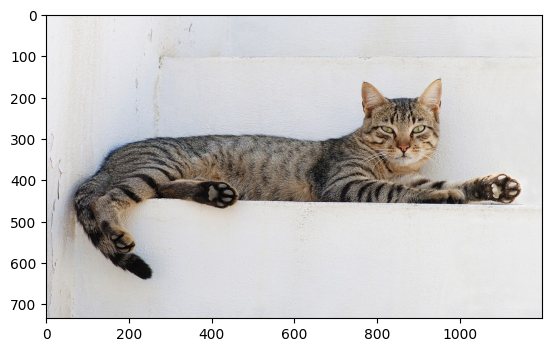

In [7]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Cat_August_2010-4.jpg/1200px-Cat_August_2010-4.jpg"
image = np.array(Image.open(urllib.request.urlopen(urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"}))))
plt.imshow(image)
print(image.shape)

In [8]:
@numba.cuda.jit
def gauss(src, kernel, dst):
  x, y = numba.cuda.grid(2)

  if x < dst.shape[0] and y < dst.shape[1]:
    half_kernel_h = kernel.shape[0] // 2
    half_kernel_w = kernel.shape[1] // 2
    acc_0 = 0
    acc_1 = 0
    acc_2 = 0
    for i in range(kernel.shape[0]):
      for j in range(kernel.shape[1]):
        xi = x + i - half_kernel_h
        yj = y + j - half_kernel_w

        if (0 <= xi < src.shape[0]) and (0 <= yj < src.shape[1]):
          acc_0 += src[xi, yj, 0] * kernel[i, j]
          acc_1 += src[xi, yj, 1] * kernel[i, j]
          acc_2 += src[xi, yj, 2] * kernel[i, j]
    dst[x, y, 0] = acc_0
    dst[x, y, 1] = acc_1
    dst[x, y, 2] = acc_2


In [9]:
kernel = np.array([
  [0, 0, 1, 2, 1, 0, 0],
  [0, 3, 13, 22, 13, 3, 0],
  [1, 13, 59, 97, 59, 13, 1],
  [2, 22, 97, 159, 97, 22, 2],
  [1, 13, 59, 97, 59, 13, 1],
  [0, 3, 13, 22, 13, 3, 0],
  [0, 0, 1, 2, 1, 0, 0],
])
kernel = kernel / kernel.sum()

In [24]:
block_size = (32, 32)
grid_size = (math.ceil(image.shape[0] / block_size[0]), math.ceil(image.shape[1] / block_size[1]))

src = numba.cuda.to_device(image)
dst = numba.cuda.device_array(image.shape, image.dtype)
device_kernel = numba.cuda.to_device(kernel)


no_avg = 10000
start = time.time()
for _ in range(no_avg):
  gauss[grid_size, block_size](src, kernel, dst)
end = time.time()
d = (end - start) / no_avg
print(d)

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


0.002958097314834595


In [ ]:
output = dst.copy_to_host()

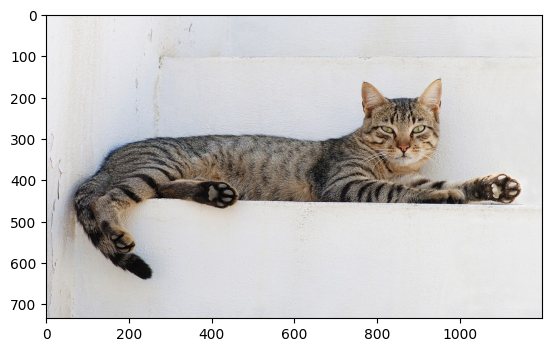

In [25]:
plt.imshow(image)

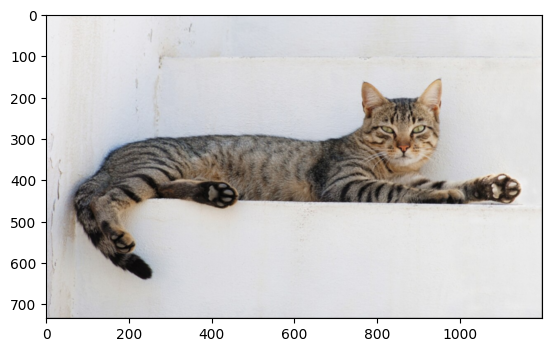

In [12]:
plt.imshow(output)

In [13]:
@numba.cuda.jit
def gauss_shared_kernel(src, kernel, dst):
  x, y = numba.cuda.grid(2)


  shared_kernel = numba.cuda.shared.array(shape=(7, 7), dtype=kernel.dtype)
  threadx = numba.cuda.threadIdx.x
  thready = numba.cuda.threadIdx.y
  if (threadx < kernel.shape[0]) and (thready < kernel.shape[1]):
    shared_kernel[threadx, thready] = kernel[threadx, thready]
  numba.cuda.syncthreads()

  if x < dst.shape[0] and y < dst.shape[1]:
    half_kernel_h = kernel.shape[0] // 2
    half_kernel_w = kernel.shape[1] // 2
    acc_0 = 0
    acc_1 = 0
    acc_2 = 0
    for i in range(kernel.shape[0]):
      for j in range(kernel.shape[1]):
        xi = x + i - half_kernel_h
        yj = y + j - half_kernel_w

        if (0 <= xi < src.shape[0]) and (0 <= yj < src.shape[1]):
          kernel_val = shared_kernel[i, j]
          acc_0 += src[xi, yj, 0] * kernel_val
          acc_1 += src[xi, yj, 1] * kernel_val
          acc_2 += src[xi, yj, 2] * kernel_val
    dst[x, y, 0] = acc_0
    dst[x, y, 1] = acc_1
    dst[x, y, 2] = acc_2


In [26]:
block_size = (32, 32)
grid_size = (math.ceil(image.shape[0] / block_size[0]), math.ceil(image.shape[1] / block_size[1]))

src = numba.cuda.to_device(image)
dst = numba.cuda.device_array(image.shape, image.dtype)
device_kernel = numba.cuda.to_device(kernel)


no_avg = 10000
start = time.time()
for _ in range(no_avg):
  gauss_shared_kernel[grid_size, block_size](src, kernel, dst)
end = time.time()
d1 = (end - start) / no_avg
print(d1)
print("speed up:", d1/ d)

0.003104112195968628
speed up: 1.0493610809900613


In [17]:
@numba.cuda.jit
def gauss_shared_src(src, kernel, dst):
  x, y = numba.cuda.grid(2)


  shared_src = numba.cuda.shared.array(shape=(32 + 6, 32 + 6, 3), dtype=kernel.dtype)
  threadx = numba.cuda.threadIdx.x
  thready = numba.cuda.threadIdx.y

  block_top = numba.cuda.blockIdx.x * 32
  block_left = numba.cuda.blockIdx.y * 32

  for i in range(threadx, 32+6, 32):
    xi = block_top + i - 3
    for j in range(thready, 32+6, 32):
      yj = block_left + j - 3
      if (0 <= xi < src.shape[0]) and (0 <= yj < src.shape[1]):
        shared_src[i, j, 0] = src[xi, yj, 0]
        shared_src[i, j, 1] = src[xi, yj, 1]
        shared_src[i, j, 2] = src[xi, yj, 2]
      else:
        shared_src[i, j, 0] = 0
        shared_src[i, j, 1] = 0
        shared_src[i, j, 2] = 0
  numba.cuda.syncthreads()

  if x < dst.shape[0] and y < dst.shape[1]:
    acc_0 = 0
    acc_1 = 0
    acc_2 = 0
    for i in range(kernel.shape[0]):
      for j in range(kernel.shape[1]):
        xi = threadx + i
        yj = thready + j
        kernel_val = kernel[i, j]
        acc_0 += shared_src[xi, yj, 0] * kernel_val
        acc_1 += shared_src[xi, yj, 1] * kernel_val
        acc_2 += shared_src[xi, yj, 2] * kernel_val
    dst[x, y, 0] = acc_0
    dst[x, y, 1] = acc_1
    dst[x, y, 2] = acc_2


In [27]:
block_size = (32, 32)
grid_size = (math.ceil(image.shape[0] / block_size[0]), math.ceil(image.shape[1] / block_size[1]))

src = numba.cuda.to_device(image)
dst = numba.cuda.device_array(image.shape, image.dtype)
device_kernel = numba.cuda.to_device(kernel)


no_avg = 10000
start = time.time()
for _ in range(no_avg):
  gauss_shared_src[grid_size, block_size](src, kernel, dst)
end = time.time()
d2 = (end - start) / no_avg
print(d2)
print("speed up vs original:", d2 / d)
print("speed up vs share kernel:", d2 / d1)

output = dst.copy_to_host()

0.0018239830493927002
speed up vs original: 0.6166068439485028
speed up vs share kernel: 0.5876021658500434
